In [93]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import ListedColormap


from statsmodels.stats.proportion import proportions_ztest
from scipy.stats import mannwhitneyu, ttest_ind

from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

import warnings

In [94]:
# Set display options
pd.set_option('display.max_columns', None)
warnings.filterwarnings('ignore')

In [95]:
# Load the processed data as pickle files to keep data types
data_processed = "../data/processed"
apps = pd.read_pickle(f"{data_processed}/applications.pkl")
company = pd.read_pickle(f"{data_processed}/company.pkl")
payments = pd.read_pickle(f"{data_processed}/payment.pkl")
df = pd.read_pickle(f"{data_processed}/merged.pkl")


## Task 1.2 Construction Segment Characteristics

Looking at the characteristics of the **Construction segment** compared to other segments to see whether there are any significant differences in  business characteristics.

### 1.2.1 `external_credit_rating`

**Question:** What type of `external_credit_rating` do Construction sector companies have?

In [96]:
# Drop rows with missing type_of_external_credit_rating
company_copy = company.copy(deep=True)
rating_type_df = company_copy.dropna(subset=['type_of_external_credit_rating'])

# Create a cross-tabulation of counts
rating_type_counts = pd.crosstab(
    company_copy['type_of_external_credit_rating'],
    company_copy['is_construction'],
    rownames=['Type of External Credit Rating'],
    colnames=['Is Construction']
)

# Optional: Rename columns for clarity
rating_type_counts.columns = ['Non-Construction', 'Construction']

# Display the table
rating_type_counts

,Non-Construction,Construction
Type of External Credit Rating,,
Analysed - Non balancing,1,0
External credit risk,992,342
Non trading,1,0
Royal Charter Company,1,0
unknown,121,0


All Construction companies have an `external_credit_rating` of either 'Very Low Risk', 'Low Risk', 'Moderate Risk' or 'High Risk'.

**Question**: From the companies with rated `external_credit_rating`s, what proportion of Construction companies fall into each category compared to others?

          rating  construction_prop  non_construction_prop    z_stat   p_value
3  Very Low Risk           0.157895               0.267025 -4.125918  0.000037
1       Low Risk           0.432749               0.329749  3.485045  0.000492
2  Moderate Risk           0.383041               0.264337  4.223230  0.000024
4      High Risk           0.026316               0.027778 -0.144810  0.884861
0            NaN           0.000000               0.000000       NaN       NaN


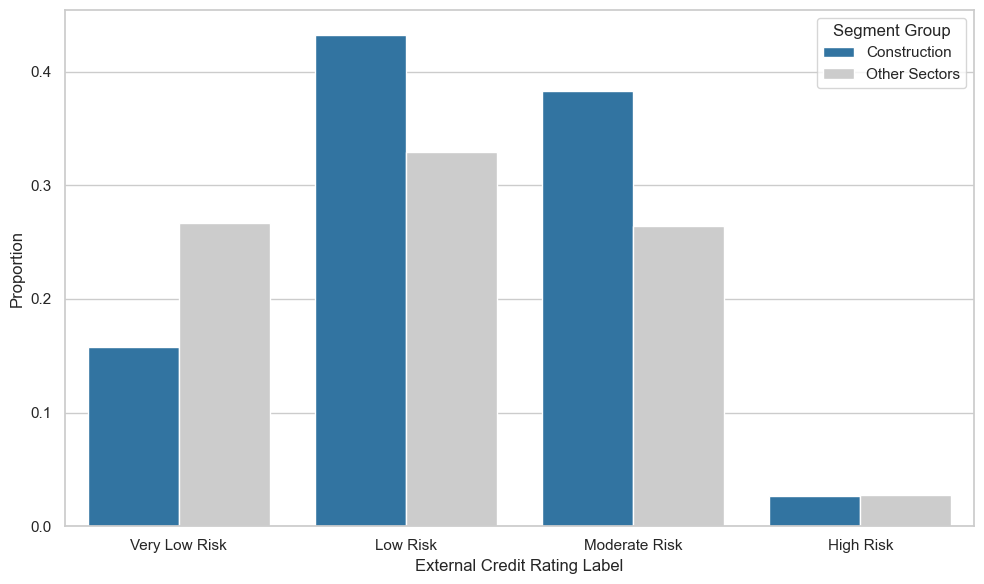

In [97]:
# Loop over each rating category
company_copy = company.copy(deep=True)
results = []
for rating in company_copy['external_credit_rating_label'].unique():
    # Create binary outcome for whether a company is in this rating
    company_copy['in_rating'] = company_copy['external_credit_rating_label'] == rating

    # Group counts for construction and non-construction
    k_constr = company_copy[(company_copy['is_construction']) & (company_copy['in_rating'])].shape[0]
    k_other  = company_copy[(~company_copy['is_construction']) & (company_copy['in_rating'])].shape[0]

    n_constr = company_copy[company_copy['is_construction']].shape[0]
    n_other  = company_copy[~company_copy['is_construction']].shape[0]

    # Z-test
    count = [k_constr, k_other]
    nobs = [n_constr, n_other]
    stat, pval = proportions_ztest(count, nobs)

    # Collect results
    results.append({
        'rating': rating,
        'construction_prop': k_constr / n_constr,
        'non_construction_prop': k_other / n_other,
        'z_stat': stat,
        'p_value': pval
    })

# Define the ordinal order for the rating labels
rating_order = [
    'Very Low Risk',
    'Low Risk',
    'Moderate Risk',
    'High Risk'
]

# Convert to DataFrame
results_company_copy = pd.DataFrame(results)#.sort_values(by='p_value')
results_company_copy['rating'] = pd.Categorical(
    results_company_copy['rating'],
    categories=rating_order,
    ordered=True
)

# Order by riskiness
results_company_copy = results_company_copy.sort_values(by='rating')
print(results_company_copy)

# Reshape the DataFrame to long format
company_copy = company.copy(deep=True)
plot_df = results_company_copy.melt(
    id_vars='rating',
    value_vars=['construction_prop', 'non_construction_prop'],
    var_name='segment_group',
    value_name='proportion'
)

# Map segment_group to readable labels
plot_df['segment_group'] = plot_df['segment_group'].map({
    'construction_prop': 'Construction',
    'non_construction_prop': 'Other Sectors'
})

# Create the bar plot
plt.figure(figsize=(10, 6))
sns.barplot(
    data=plot_df,
    x='rating',
    y='proportion',
    hue='segment_group',
    palette={"Construction": "#1f77b4", "Other Sectors": "#cccccc"}
)

# Style the plot
# plt.title("Proportion of Companies by Credit Rating Category")
plt.ylabel("Proportion")
plt.xlabel("External Credit Rating Label")
plt.legend(title="Segment Group")
plt.tight_layout()
plt.show()


The results indicate that the proportion of construction companies which fall into the categories 'Very Low Risk', 'Low Risk' and 'Moderate Risk' are significantly different from other companies. The proportion of construction companies which fall into the category 'High Risk' is not picked up as a statistically significantly difference from other companies. 

We can see that:
1. There are **fewer** construction companies in the 'Very Low Risk' rating category compared to the other industries.
2. There are **more** construction companies in the 'Low Risk' and 'Moderate Risk' rating category compared to the other industries.

### 1.2.2 `net_worth` & `working_capital`

Analysis on the Net Worth and Working Capital for Construction vs other Industry Sectors

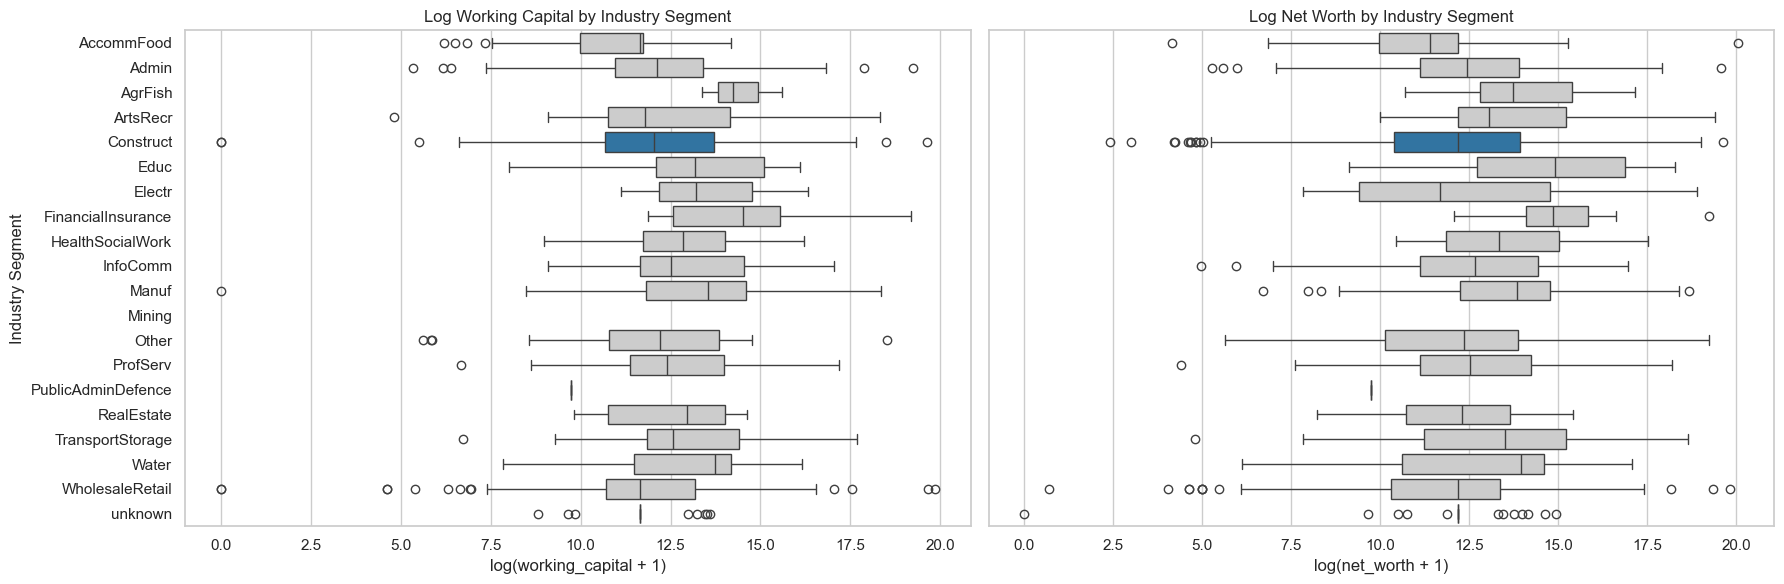

In [98]:

# Define consistent color palette
industry_palette = company["industry_segment"].unique()
my_palette = {seg: ("#1f77b4" if seg == "Construct" else "#cccccc") for seg in industry_palette}

# Plot boxplots
fig, axs = plt.subplots(1, 2, figsize=(18, 6), sharey=True)

sns.boxplot(data=company, y="industry_segment", x="log_working_capital", palette=my_palette, ax=axs[0])
axs[0].set_title("Log Working Capital by Industry Segment")
axs[0].set_xlabel("log(working_capital + 1)")
axs[0].set_ylabel("Industry Segment")

sns.boxplot(data=company, y="industry_segment", x="log_net_worth", palette=my_palette, ax=axs[1])
axs[1].set_title("Log Net Worth by Industry Segment")
axs[1].set_xlabel("log(net_worth + 1)")
axs[1].set_ylabel("")

plt.tight_layout()
plt.show()

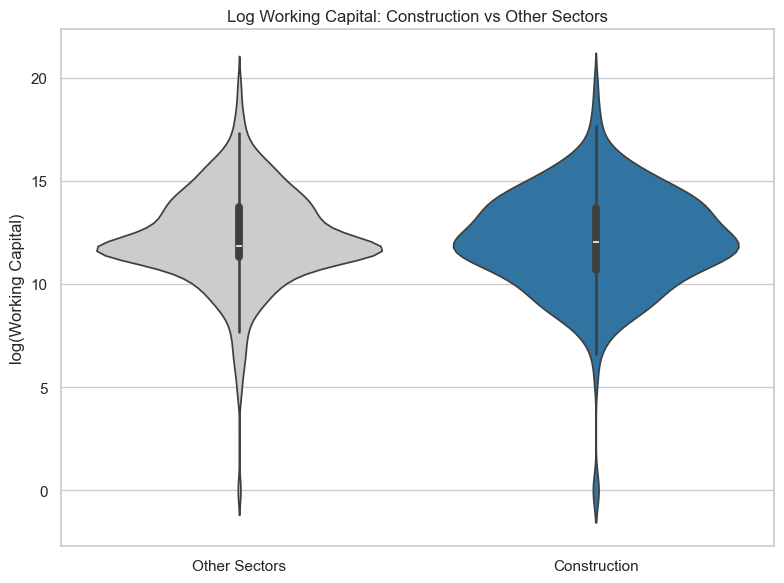

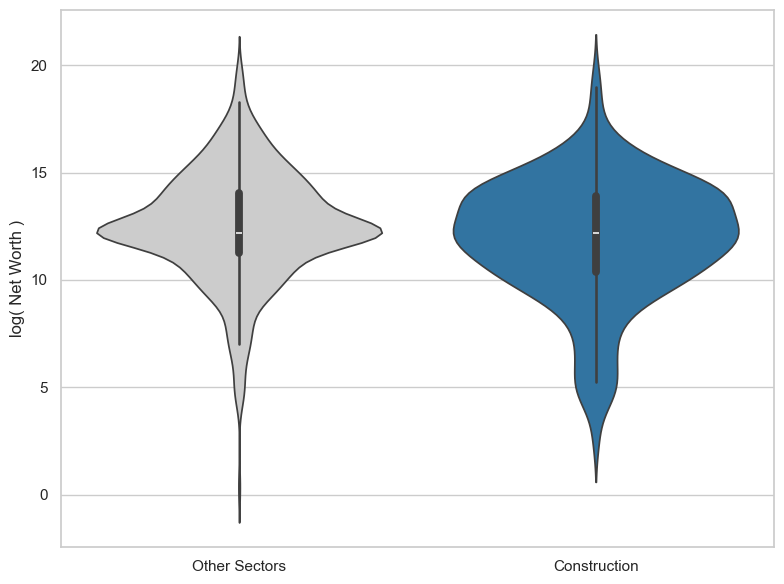

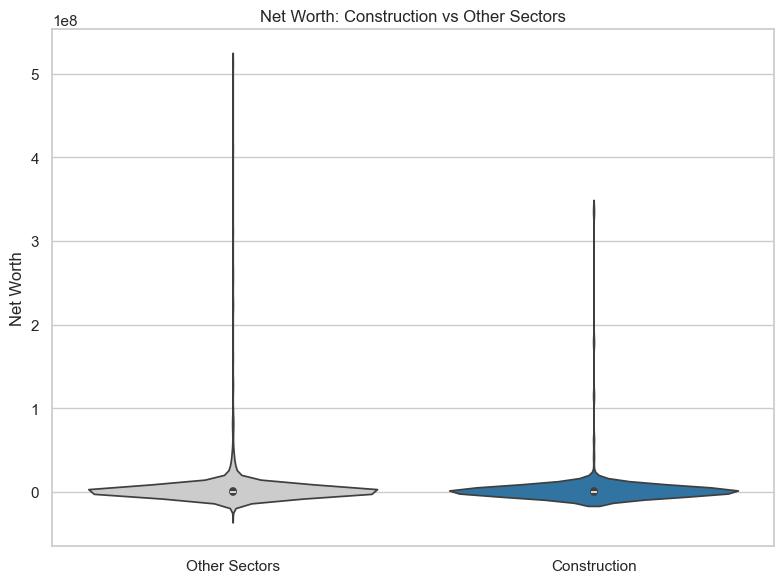

In [99]:
# --- First plot: Log Working Capital ---
plt.figure(figsize=(8, 6))
sns.violinplot(
    data=company,
    x="sector_group",
    y="log_working_capital",
    palette={"Construction": "#1f77b4", "Other Sectors": "#cccccc"}
)
plt.title("Log Working Capital: Construction vs Other Sectors")
plt.ylabel("log(Working Capital)")
plt.xlabel("")
plt.tight_layout()
plt.show()

# --- Second plot: Log Net Worth ---
plt.figure(figsize=(8, 6))
sns.violinplot(
    data=company,
    x="sector_group",
    y="log_net_worth",
    palette={"Construction": "#1f77b4", "Other Sectors": "#cccccc"}
)
# plt.title("Log Net Worth: Construction vs Other Sectors")
plt.ylabel("log( Net Worth )")
plt.xlabel("")
plt.tight_layout()
plt.show()

# Violin plot for raw Net Worth (not log-transformed)
plt.figure(figsize=(8, 6))
sns.violinplot(
    data=company,
    x="sector_group",
    y="net_worth",
    palette={"Construction": "#1f77b4", "Other Sectors": "#cccccc"}
)
plt.title("Net Worth: Construction vs Other Sectors")
plt.ylabel("Net Worth")
plt.xlabel("")
plt.tight_layout()
plt.show()

The violin plots suggest that the median log working capital and log net worth are similar, however the distribution for the Construction sector for both log working capital and log net worth looks more dispersed/varied. We can perform Mann-Whitney U tests to determine whether these differences in distribution are significant.

In [100]:

# -------------------------
# 1) Net Worth
# -------------------------
raw_nw_constr = company.loc[company["is_construction"], "net_worth"].dropna()
raw_nw_others   = company.loc[~company["is_construction"], "net_worth"].dropna()

med_nw_constr = company.loc[company["is_construction"], "net_worth"].median()
med_nw_others = company.loc[~company["is_construction"], "net_worth"].median()

mw_raw_nw = mannwhitneyu(raw_nw_constr, raw_nw_others, alternative="two-sided")

print("=== Net Worth ===")
print(f"Median Net Worth [Construction]:     {med_nw_constr:.6f}")
print(f"Median Net Worth [Other Sectors]:    {med_nw_others:.6f}")
print(f"Mann–Whitney U on Net Worth: p =     {mw_raw_nw.pvalue:.6f}\n")

# -------------------------
# 2) Log(Net Worth) 
# -------------------------
log_nw_constr = company.loc[company["is_construction"], "log_net_worth"].dropna()
log_nw_others = company.loc[~company["is_construction"], "log_net_worth"].dropna()

med_log_nw_constr = log_nw_constr.median()
med_log_nw_others = log_nw_others.median()

mw_log_nw = mannwhitneyu(log_nw_constr, log_nw_others, alternative="two-sided")

print("=== Log(Net Worth) ===")
print(f"Median Log(Net Worth) [Construction]:     {med_log_nw_constr:.6f}")
print(f"Median Log(Net Worth) [Other Sectors]:    {med_log_nw_others:.6f}")
print(f"Mann–Whitney U on Log(Net Worth): p =     {mw_log_nw.pvalue:.6f}\n")

# -------------------------
# 3) Raw Working Capital
# -------------------------
raw_wc_constr = company.loc[company["is_construction"], "working_capital"].dropna()
raw_wc_others = company.loc[~company["is_construction"], "working_capital"].dropna()

med_wc_constr = raw_wc_constr.median()
med_wc_others = raw_wc_others.median()

mw_wc_raw = mannwhitneyu(raw_wc_constr, raw_wc_others, alternative="two-sided")

print("=== Raw Working Capital ===")
print(f"Median Working Capital [Construction]:     {med_wc_constr}")
print(f"Median Working Capital [Other Sectors]:    {med_wc_others}")
print(f"Mann–Whitney U on Raw Working Capital: p = {mw_wc_raw.pvalue:.6f}\n")

# -------------------------
# 4) Log(Working Capital)
# -------------------------
log_wc_constr = company.loc[company["is_construction"], "log_working_capital"].dropna()
log_wc_others = company.loc[~company["is_construction"], "log_working_capital"].dropna()

med_log_wc_constr = log_wc_constr.median()
med_log_wc_others = log_wc_others.median()

mw_wc_log = mannwhitneyu(log_wc_constr, log_wc_others, alternative="two-sided")

print("=== Log(Working Capital) ===")
print(f"Median Log(Working Capital) [Construction]:  {med_log_wc_constr:.6f}")
print(f"Median Log(Working Capital) [Other Sectors]: {med_log_wc_others:.6f}")
print(f"Mann–Whitney U on Log(Working Capital): p =  {mw_wc_log.pvalue:.6f}")


=== Net Worth ===
Median Net Worth [Construction]:     175048.500000
Median Net Worth [Other Sectors]:    194692.000000
Mann–Whitney U on Net Worth: p =     0.179066

=== Log(Net Worth) ===
Median Log(Net Worth) [Construction]:     12.179179
Median Log(Net Worth) [Other Sectors]:    12.179179
Mann–Whitney U on Log(Net Worth): p =     0.001457

=== Raw Working Capital ===
Median Working Capital [Construction]:     114254.0
Median Working Capital [Other Sectors]:    114254.0
Mann–Whitney U on Raw Working Capital: p = 0.339899

=== Log(Working Capital) ===
Median Log(Working Capital) [Construction]:  12.043048
Median Log(Working Capital) [Other Sectors]: 11.861312
Mann–Whitney U on Log(Working Capital): p =  0.405476


📊 Net Worth: (A measure of solvency.)

- **Median (raw)**  
  - Construction: £175,049  
  - Other sectors: £194,692  
  - **Mann–Whitney U p-value**: 0.179 → *Not significant*

- **Median (log)**  
  - Construction: 12.18  
  - Other sectors: 12.18  
  - **Mann–Whitney U p-value**: 0.0015 → ✅ *Statistically significant*

While the **log-transformed medians** are the same, the **distributions differ significantly**. This indicates that Construction firms may have more variation, some with very high or very low net worth, even if the central value is similar. This difference in distribution shape (not center) is picked up by the Mann–Whitney U test.

📊 Working Capital: (A measure of liquidity.)

- **Median (raw)**  
  - Construction: £114,254  
  - Other sectors: £114,254  
  - **Mann–Whitney U p-value**: 0.340 → *Not significant*

- **Median (log)**  
  - Construction: 12.04  
  - Other sectors: 11.86  
  - **Mann–Whitney U p-value**: 0.405 → *Not significant*

Working capital distributions appear broadly similar between Construction and other sectors, both in scale and spread.

🧠 Interpretation and Next Steps

Log transformations reduce skew and emphasize **relative differences** instead of **absolute pound values**. The fact that net worth shows a statistically significant difference *only* after log transformation suggests that:

- **Construction firms differ more in scale (ratio terms)** than in raw cash terms.
- The **variation** among Construction firms is relevant to credit risk—some are much larger or smaller than others.

This makes log-transformed net worth a potentially more informative feature for risk modeling.

How This Informs Risk Profiling

- The **Construction sector exhibits higher dispersion** in net worth than other sectors, despite identical medians.
- This justifies:
  - Including **log(net_worth)** in modeling as a key feature.
  - Considering **sector segmentation** (e.g., training separate models or tuning thresholds for Construction firms).
  - Exploring **interactions** between financial variables and sector labels.

### 1.2.3 `company_age`

**Question:** How does company age for the Construction sector differ from the other sectors?

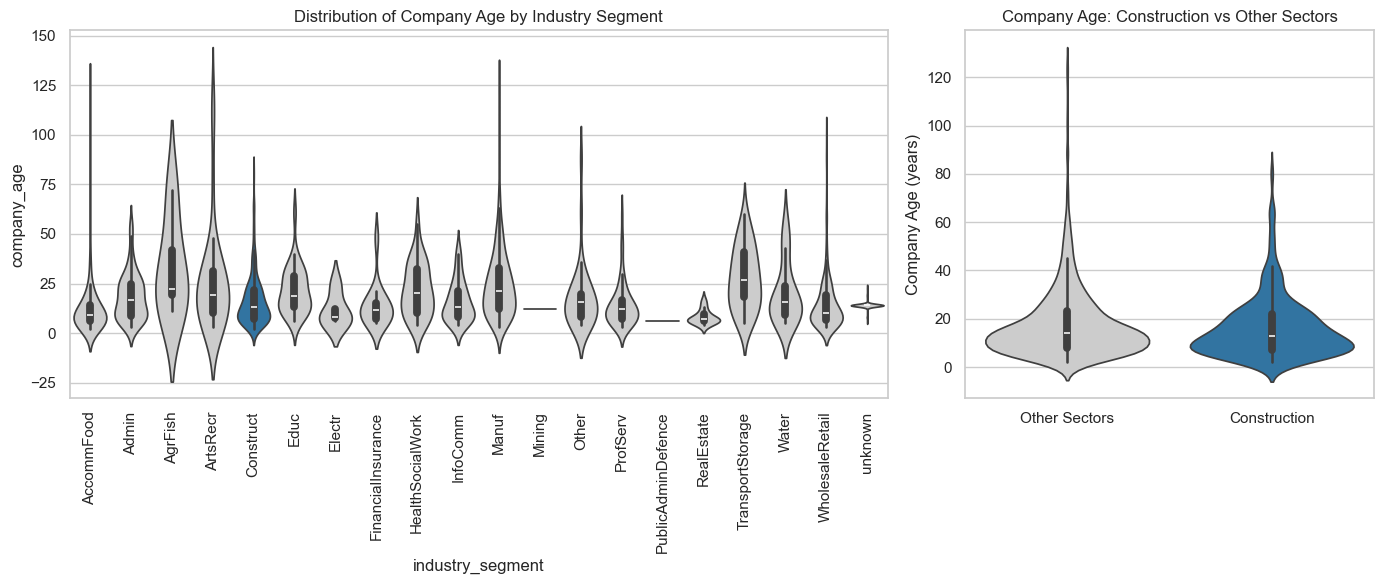

In [101]:
company_copy = company.copy(deep=True)
# Create figure and axes with width ratios: first plot 2x wider than second
fig, (ax1, ax2) = plt.subplots(
    1, 2,
    figsize=(14, 6),  # Total width x height
    gridspec_kw={'width_ratios': [2, 1]}  # First plot twice as wide as second
)

# First violin plot: company age by industry_segment
sns.violinplot(
    x='industry_segment',
    y='company_age',
    data=company_copy,
    palette=my_palette,
    ax=ax1
)
ax1.set_xticklabels(ax1.get_xticklabels(), rotation=90)
ax1.set_title('Distribution of Company Age by Industry Segment')

# Second violin plot: company age Construction vs Other Sectors
sns.violinplot(
    data=company_copy,
    x="sector_group",
    y="company_age",
    palette={"Construction": "#1f77b4", "Other Sectors": "#cccccc"},
    ax=ax2
)
ax2.set_title("Company Age: Construction vs Other Sectors")
ax2.set_ylabel("Company Age (years)")
ax2.set_xlabel("")

plt.tight_layout()
plt.show()

### 1.2.4 `legal_form`

**Question:** How does legal form for the Construction sector differ from the other sectors?

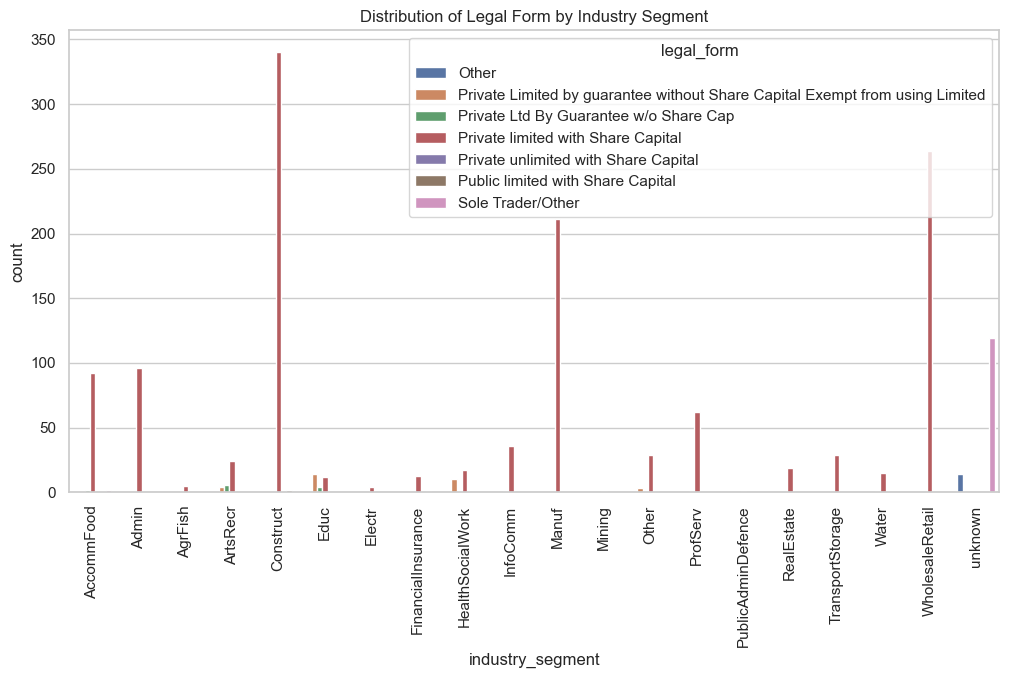

In [102]:
# 2. Grouped bar chart for legal_form by industry_segment
plt.figure(figsize=(12,6))
sns.countplot(x='industry_segment', hue='legal_form', data=company_copy)
plt.xticks(rotation=90)
plt.title('Distribution of Legal Form by Industry Segment')
plt.show()

All the Construction sector companies are Private Limited Companies with Share Capital and so this feature is unlikely to help in the analysis.

# Task 1.3 Key Risk Metric Calculations from `payments`

## 1.3.1 Default Rate

> Is the default rate in the Construction segment different from the default rate in all other segments?


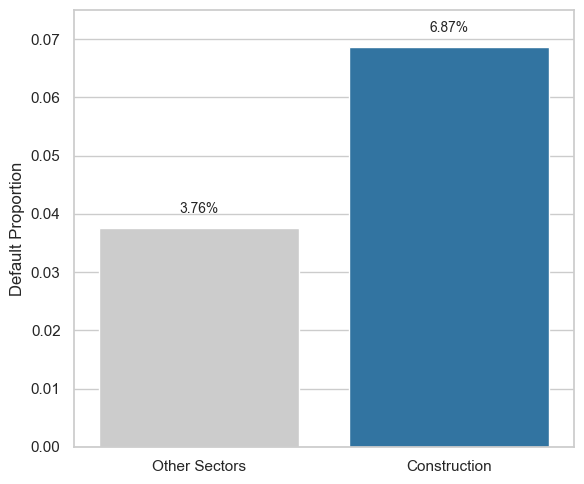

In [104]:
blue_construction_palette = {"Construction": "#1f77b4", "Other Sectors": "#cccccc"}

# Group by sector and calculate count and proportion
summary = (
    df.groupby('sector_group')['default_status']
    .agg(['sum', 'count'])
    .rename(columns={'sum': 'defaults', 'count': 'total'})
)
summary['proportion'] = summary['defaults'] / summary['total']
summary = summary.reset_index()

# Set explicit category order
summary['sector_group'] = pd.Categorical(
    summary['sector_group'],
    categories=['Other Sectors', 'Construction'],  # Desired order
    ordered=True
)
summary = summary.sort_values('sector_group')

# Plot
plt.figure(figsize=(6, 5))
ax = sns.barplot(
    data=summary,
    x='sector_group',
    y='proportion',
    palette=blue_construction_palette
)

# Correctly match text to each bar
for patch, proportion in zip(ax.patches, summary['proportion']):
    x = patch.get_x() + patch.get_width() / 2
    y = patch.get_height()
    ax.text(x, y + 0.002, f"{proportion:.2%}", ha='center', va='bottom', fontsize=10)

plt.ylabel('Default Proportion')
plt.xlabel('')
plt.ylim(0, 0.075)
plt.tight_layout()
plt.show()

### Hypotheses

- **Null hypothesis (H₀):**  
  $
  p_{C} \le p_{O}
  $  
  The default proportion in Construction is less than or equal to that in Other industries.

- **Alternative hypothesis (H₁):**  
  $
  p_{C} > p_{O}
  $  
  The default proportion in Construction is greater than that in Other industries.

### When to Use a Two-Proportion Z-Test

- You have **two independent groups**:  
  1. Construction firms  
  2. All other firms
- You observe a **binary outcome** in each group: default (`True`) or no default (`False`).
- You wish to test whether the underlying population proportions $p_C$ and $p_O$ are equal.

### Assumptions

1. **Independence** of observations within and between groups.  
2. **Sample sizes** large enough for normal approximation:  
   $n_C \hat p \ge 5,\; n_C(1-\hat p)\ge 5$, and similarly for $n_O$.

### Interpretation

- If **p-value < 0.05**, conclude that Construction firms have a **significantly higher** default rate than other industries at the 5% level.  
- If **p-value ≥ 0.05**, there is insufficient evidence to claim Construction’s default rate is higher.    

In [105]:
# 1. Total bills in each group
n_constr = df[df['is_construction']].shape[0]   # e.g., 757
n_other  = df[~df['is_construction']].shape[0]  # e.g., 3243

# 2. Number of defaults in each group
k_constr = df[(df['is_construction']) & (df['default_status'])].shape[0]
k_other  = df[(~df['is_construction']) & (df['default_status'])].shape[0]

print(f"Construction: {k_constr}/{n_constr} defaults  → rate = {k_constr/n_constr:.3%}")
print(f"Other segs : {k_other}/{n_other} defaults  → rate = {k_other/n_other:.3%}\n")

# 3. One‐sided two‐proportion Z-test (testing p_constr > p_other)
counts = [k_constr, k_other]
nobs   = [n_constr, n_other]

stat, pval_one_sided = proportions_ztest(
    count=counts,
    nobs=nobs,
    alternative='larger'   # one-sided: tests p1 > p2
)

print(f"Z-statistic       = {stat:.5f}")
print(f"One‐sided p-value = {pval_one_sided:.5f}")

# 4. Interpret at α = 0.05
alpha = 0.05
if pval_one_sided < alpha:
    print(f"→ Reject H₀: Construction’s default rate is significantly higher (p < {alpha}).")
else:
    print(f"→ Fail to reject H₀: No evidence that Construction’s default rate is higher (p ≥ {alpha}).")

Construction: 52/757 defaults  → rate = 6.869%
Other segs : 122/3243 defaults  → rate = 3.762%

Z-statistic       = 3.77384
One‐sided p-value = 0.00008
→ Reject H₀: Construction’s default rate is significantly higher (p < 0.05).


## 1.3.2 On-time Payments

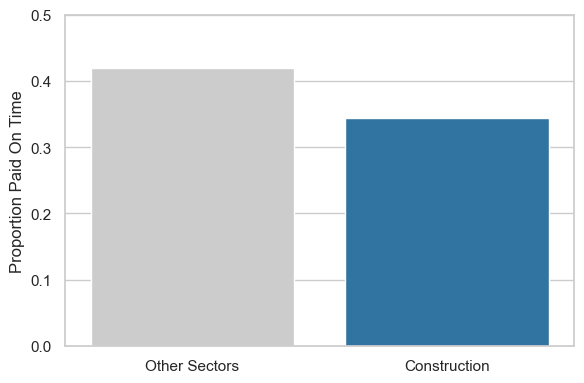

In [106]:
# Calculate proportion of payments paid on time
proportions = df.groupby('sector_group')['paid_on_time'].mean().reset_index()

# Plot with Construction on the right
sns.set_theme(style="whitegrid")
plt.figure(figsize=(6, 4))
sns.barplot(
    data=proportions,
    x='sector_group',
    y='paid_on_time',
    palette={"Construction": "#1f77b4", "Other Sectors": "#cccccc"},
    order=['Other Sectors', 'Construction']  # Explicit order
)
# plt.title("Proportion of Payments Paid On Time")
plt.ylabel("Proportion Paid On Time")
plt.xlabel("")
plt.ylim(0, 0.5)
plt.tight_layout()
plt.show()

In [107]:
# Counts of on-time payments
construction_paid = df[df['sector_group'] == 'Construction']['paid_on_time'].sum()
other_paid = df[df['sector_group'] == 'Other Sectors']['paid_on_time'].sum()

# Total counts
construction_total = df[df['sector_group'] == 'Construction'].shape[0]
other_total = df[df['sector_group'] == 'Other Sectors'].shape[0]

# Run two-proportion z-test
count = [construction_paid, other_paid]
nobs = [construction_total, other_total]

stat, pval = proportions_ztest(count, nobs)

print("Z-statistic:", stat)
print("p-value:", pval)

Z-statistic: -3.830616605114881
p-value: 0.00012782254101785019


## 1.3.3 Distribution of days past due date

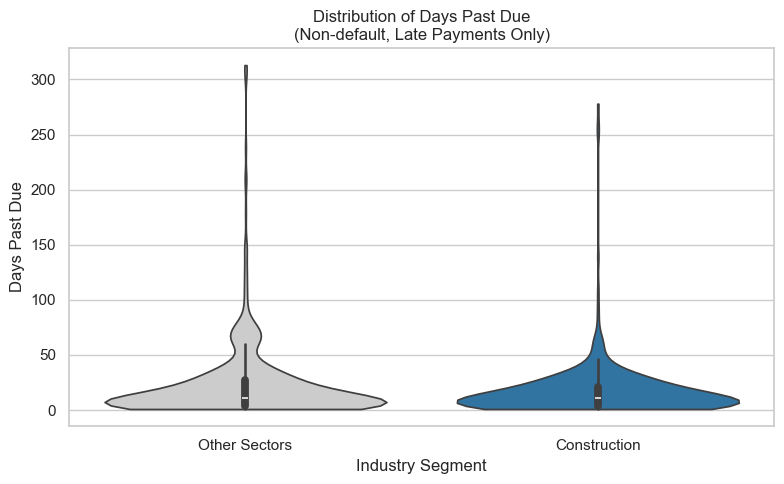

In [108]:
# Step 1: Filter the DataFrame
filtered_df = df[
    (df['default_status'] == False) & 
    (df['paid_on_time'] == False)
].copy()

# Step 3: Plot violin plot
plt.figure(figsize=(8, 5))
sns.violinplot(
    data=filtered_df,
    x='sector_group',
    y='days_past_due',
    palette={"Construction": "#1f77b4", "Other Sectors": "#cccccc"},
    cut=0  # prevents violin from extending beyond actual data
)

# Step 4: Aesthetics
plt.title("Distribution of Days Past Due\n(Non-default, Late Payments Only)")
plt.xlabel("Industry Segment")
plt.ylabel("Days Past Due")
plt.tight_layout()
plt.show()

## 1.3.4 Size of Requested Amounts

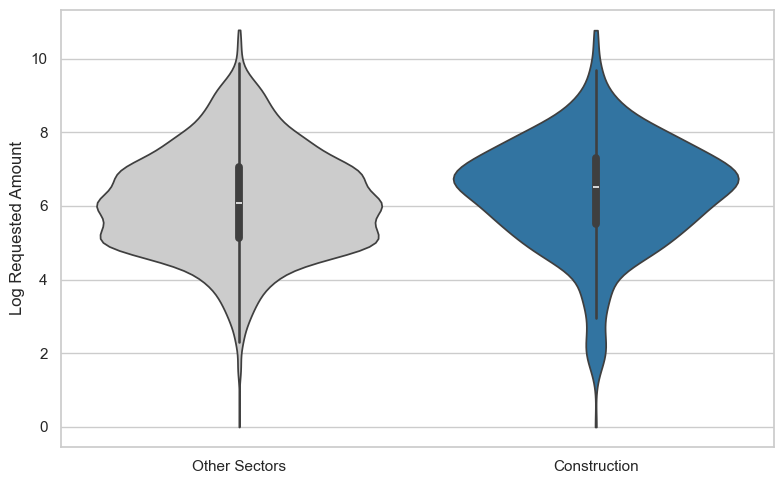

In [109]:
# Violin plot
plt.figure(figsize=(8, 5))
sns.violinplot(
    data=df,
    x='sector_group',
    y='log_requested_amount',
    palette={"Construction": "#1f77b4", "Other Sectors": "#cccccc"},
    cut=0
)

# Aesthetics
# plt.title("Log-Transformed Distribution of Requested Amounts by Sector")
plt.xlabel("")
plt.ylabel("Log Requested Amount")
plt.tight_layout()
plt.show()

In [110]:
# Extract the log-transformed values
construction_log = df[df['sector_group'] == 'Construction']['log_requested_amount']
other_log = df[df['sector_group'] == 'Other Sectors']['log_requested_amount']

# Run the test
stat, p = mannwhitneyu(construction_log, other_log, alternative='two-sided')

print("Mann–Whitney U test statistic:", stat)
print(f"p-value: {p:.10f}")

Mann–Whitney U test statistic: 1387403.0
p-value: 0.0000000227


In [111]:
# Select numeric features for comparison
num_features = [
    'invoice_amount_clean',
    'days_past_due',
    'risk_score'
]

# 3. Compute summary statistics by segment
print("### Summary Statistics (Construction vs Others)")
display(df.groupby('is_construction')[num_features] \
                  .agg(['mean', 'median', 'std', 'count']))

### Summary Statistics (Construction vs Others)


invoice_amount_clean                           days_past_due  \
                                mean median          std count          mean   
is_construction                                                                
False                    1259.967623  435.0  2745.343460  3243      7.177647   
True                     1452.247028  672.0  3210.020271   757      6.627019   

                                        risk_score                         
                median        std count       mean median       std count  
is_construction                                                            
False              2.0  32.993291  3051   4.788063   3.26  4.903281  3243  
True               3.0  25.494788   681   5.025244   3.26  5.188669   757

# Task 1.4 ID features correlated with default status

In [112]:
# assess the correlation between log_net_worth and log_working_capital
# Drop missing values for both columns
subset = df[['log_net_worth', 'log_working_capital']].dropna()

# Spearman correlation (optional)
print(subset.corr(method='spearman').iloc[0, 1])

0.8978520389292874


'log_net_worth', 'log_working_capital' are highly correlated and so removing one from theset of features would be advised.

In [118]:
# Prepare the data
df_model = df.copy()

cols_to_drop = [
    'invoice_id', 'payment_date', 'default_status', 'days_past_due', 
    'paid_on_time', 'incorporation_date', 'application_id', 
    'sector_group', 'log_requested_amount',
    'invoice_date', 'due_date', 'app_date_only', 
    'app_day_of_week', 'app_time',
    'invoice_amount_clean',
    'company_id',
    'postcode_area',
    'is_construction',
    'type_of_external_credit_rating',
    'net_worth', 'working_capital',
    'log_net_worth'
]

X = df_model.drop(columns=cols_to_drop)
y = df_model['default_status']

# Map for external_credit_rating_label
rating_map = {
    'Very Low Risk': 1,
    'Low Risk': 2,
    'Moderate Risk': 3,
    'High Risk': 4
}
X['external_credit_rating_label'] = X['external_credit_rating_label'].map(rating_map)

# Map for approved_amount_ord
approved_amount_map = {
    'up to 1000': 1,
    '1000-5000': 2,
    '5000-10000': 3,
    '10000-50000': 4,
    '50000-100000': 5,
    '100000-500000': 6,
    'over 500000': 7
}
X['approved_amount_ord'] = X['approved_amount_ord'].map(approved_amount_map)

cols_to_onehot = ['industry_segment', 'legal_form']

X = pd.get_dummies(X, columns=cols_to_onehot, drop_first=True)


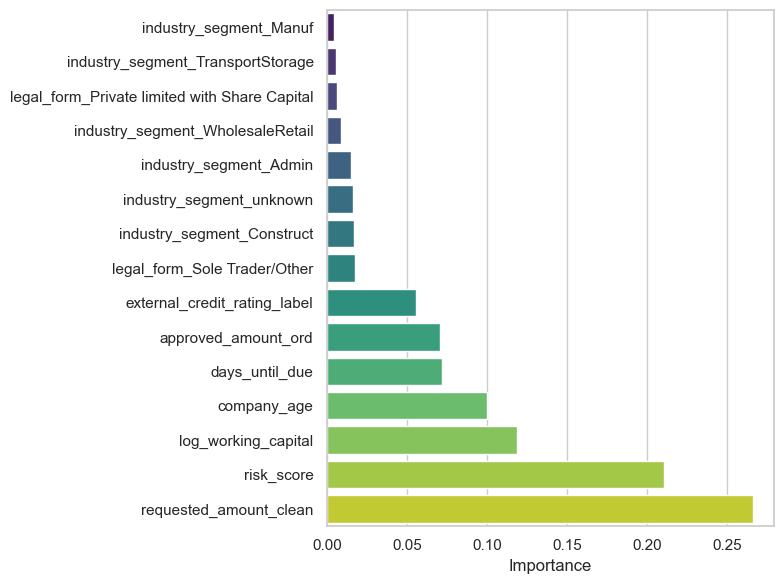

In [117]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=42)

# Fit model
rf = RandomForestClassifier(random_state=42)
rf.fit(X_train, y_train)

# Show feature importances
importances = pd.Series(rf.feature_importances_, index=X.columns).sort_values(ascending=False)

top_15 = importances.head(15).sort_values()  # sort ascending for better horizontal bar plot

plt.figure(figsize=(8, 6))
sns.barplot(x=top_15.values, y=top_15.index, palette="viridis")

# plt.title("Top 15 Feature Importances from Random Forest")
plt.xlabel("Importance")
plt.ylabel("")
plt.tight_layout()
plt.show()